In [116]:
import torch.nn as nn 
#create a network class to reuse
class Net( nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9,10)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

    def forward(self,x):
        x=nn.functional.relu(self.fc1(x))
        x=nn.functional.relu(self.fc2(x))
        x=nn.functional.relu(self.fc3(x))
        return x
    
net = Net()


In [117]:
from torch.utils.data import Dataset
import pandas as pd
class WaterDataset(Dataset):
    def __init__(self, csv_path):
        super().__init__()
        # Load data to pandas DataFrame
        df = pd.read_csv(csv_path)
        # Convert data to a NumPy array and assign to self.data
        self.data = df.to_numpy()
        
    # Implement __len__ to return the number of data samples
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        features = self.data[idx, :-1]
        # Assign last data column to label
        label = self.data[idx,-1]
        return features, label
    

dataset = WaterDataset('./data.csv')

In [118]:
from torch.utils.data import DataLoader
# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
)

# Get a batch of features and labels
features, labels = next(iter(dataloader_train))
print(features, labels)

tensor([[1, 1],
        [1, 1]]) tensor([1, 1])


In [119]:
import torch.optim as optim
optimizer = optim.Adagrad(net.parameters(),lr=0.01)# it addapts the lr
# but it may decrease the lr too fast 
optimizer2 = optim.RMSprop(net.parameters(),lr=0.01)# updates the lr based on the previous gradient
optimizer3 = optim.Adam(net.parameters(),lr=0.01) # RMSprop + gradient momentum

- vanishing gradients : when gradeints get really small and prevent model from training
- exploding gradients : when gradients gets bigger so training diverges

a way to deal with this is initialize the weights in a way that:
- variance of layer inputs = var outputs
- variance of gradients the same before and after a layer 

In [120]:
import torch.nn as nn 
import torch.nn.init as init
#create a network class to reuse
class Net( nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9,10)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight,
                            nonlinearity="sigmoid"
                            )

    def forward(self,x):
        x=nn.functional.relu(self.fc1(x))
        x=nn.functional.relu(self.fc2(x))
        x=nn.functional.sigmoid(self.fc3(x))
        # nn.functional.elu helps againts dying neurons
        return x
    
net = Net() 


batch normalisation : normalizing the output of an activation layer with mean and std of a batch

In [121]:
class Net( nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(9,10)
        self.bn1 = nn.BatchNorm1d(10)
        self.fc2 = nn.Linear(16,8)
        self.fc3 = nn.Linear(8,1)

        init.kaiming_uniform_(self.fc1.weight)
        init.kaiming_uniform_(self.fc2.weight)
        init.kaiming_uniform_(self.fc3.weight,
                            nonlinearity="sigmoid"
                            )
        def forward(self,x):
            x = self.fc1(x)
            x=nn.functional.bn1(x)
            x=nn.functional.relu(x)
            # ...
            return x
        

# Images

In [122]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
train_trainsforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(45),
    # transforms.RandomAutocontrast(),
    transforms.ToTensor(),
    transforms.Resize((128,128))
])
dataset_train = ImageFolder(
    "./clouds/clouds/clouds_train",
    transform=train_trainsforms
)

In [123]:
dataloader_train = DataLoader(
    dataset_train,
    shuffle=True,batch_size=1
)

image,label =next(iter(dataloader_train))
print(image.shape)

torch.Size([1, 3, 128, 128])


1 for batch size 

3 for the colors 

128 ,128 for height and weight


In [124]:
# to print it 
image=image.squeeze().permute(1,2,0)
print(image.shape)

torch.Size([128, 128, 3])


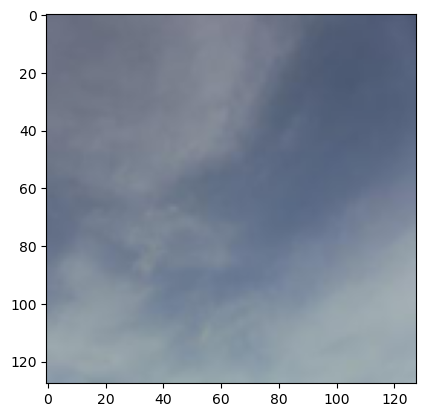

In [125]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"
import matplotlib.pyplot as plt 
plt.imshow(image)
plt.show()

In [126]:
print(label)

tensor([0])


in data augmentation we apply random tranformation to the images to get more data like rotation fliping ..

makes the model more robust to changes and variations 

In [127]:
train_trainsforms=transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(45),
    transforms.RandomAutocontrast(),
        transforms.ToTensor(),
    transforms.Resize((128,128))
])


but we usually dont use linear layer because the number of parameters will explose 
 - let say we have a 256*256 image if we put a layer of neuroons with 1000 that will be over 65M parameter

so use filters instead or convolution layers

a convolution is a the dot product betw input patch and a filter 

we often add padding of zeros to our patch to prevent loss, it ensures that the pixels at the border receive as much attention as those located elsewhere in the feature map.

max polling : it's got by sliding non overlaping window and take max in that window

Convolutional layers preserve spatial information between their inputs and outputs

In [128]:
class Net(nn.Module):
    def __init__(self, num_classes):                                                               
        super().__init__() # image start with 3*64*64 our data 
        self.feature_extractor = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1),#32*64*64
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2),#32*32*32
        nn.Conv2d(32, 64, kernel_size=3, padding=1),#64*32*32
        nn.ELU(),
        nn.MaxPool2d(kernel_size=2),#64*16*16
        nn.Flatten(),#flattening the output to array of vals
        )
        self.classifier = nn.Linear(64*32*32, num_classes)


    def forward(self, x):
        x = self.feature_extractor(x)                                                             
        x = self.classifier(x)
        return x

- data augmentation can sometimes impact the label for example flipping w vertically will make it M
- chaging color of orange to yellow will make look like lemmon but label is still orange 

In [129]:
net = Net(num_classes=7)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(),lr=0.0005)
for epoch in range(13):
    epoch_loss = 0
    for images,labels in dataloader_train:
        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs,labels)
        loss.backward()
        epoch_loss+=loss.item()
        optimizer.step()
    print("epoch loss:",epoch_loss/len(dataloader_train))


epoch loss: 1.8877666560240827
epoch loss: 1.4155219046019296
epoch loss: 1.2732839752304248
epoch loss: 1.1504163017570508
epoch loss: 1.0094370390797849
epoch loss: 0.8374237849505455
epoch loss: 0.6404952674485319
epoch loss: 0.5451160916380124
epoch loss: 0.490984368296783
epoch loss: 0.5121029884478103
epoch loss: 0.23839521445037035
epoch loss: 0.24649211549883462
epoch loss: 0.14292570662161508


In [130]:
test_transforms = transforms.Compose([
    # no data augmentation in test
    transforms.ToTensor(),
    transforms.Resize((128,128))
])

dataset_test = ImageFolder(
    './clouds/clouds/clouds_test',
    transform=test_transforms
)
dataloader_test= DataLoader(
    dataset_test,
    shuffle=True,batch_size=1
)

In [131]:
from torchmetrics import Precision,Recall
import torch
metric_precision = Precision(task="multiclass",num_classes=7,average="macro")
metric_racall = Recall(task="multiclass",num_classes=7,average="macro")
net.eval()
with torch.no_grad():
    for images,labels in dataloader_test:
        outputs = net(images)
        _,preds = torch.max(outputs,1)
        metric_precision(preds,labels)
        metric_racall(preds,labels)
precistion = metric_precision.compute()
recall = metric_racall.compute()

In [132]:
print(precistion)

tensor(0.5970)


In [133]:
print(recall)

tensor(0.6181)


evaluating the metrics per class

In [134]:
metric_racall = Recall(task="multiclass",num_classes=7,average=None)
net.eval()
with torch.no_grad():
    for images,labels in dataloader_test:
        outputs = net(images)
        _,preds = torch.max(outputs,1)
        metric_precision(preds,labels)
        metric_racall(preds,labels)
precistion = metric_precision.compute()
recall = metric_racall.compute()

In [135]:
print(recall)

tensor([0.3117, 0.9531, 0.8182, 0.5583, 0.4175, 1.0000, 0.2676])


In [136]:
{
    k:recall[v].item() 
    for k,v in 
    dataset_test.class_to_idx.items()
}

{'cirriform clouds': 0.31168830394744873,
 'clear sky': 0.953125,
 'cumulonimbus clouds': 0.8181818127632141,
 'cumulus clouds': 0.5583333373069763,
 'high cumuliform clouds': 0.41747573018074036,
 'stratiform clouds': 1.0,
 'stratocumulus clouds': 0.26760563254356384}